# Fine Tunig

### Transferencia de aprendizado (pesos) de outro modelo já pre processado muito mais imagens
### São transferidos os dados do convulucao e pooling para caracterisitica comum entre as imgs do modelo pre pronto e o nossos dados, assim consegue utilizar o peso do modelo pre pronto para muitas coisas.
 

In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from Tools.i18n.makelocalealias import optimize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout


from tensorflow.python.ops.ragged.ragged_util import lengths_to_splits

tf.__version__

'2.10.0'

## Extraindo nossas imagens


In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_W = 256 #valores que o modelo pre treinado já utilizou, deve ser a mesma dimensão
IMG_H = 256

bart_path  = './homer_bart_2/homer_bart_2/training_set/bart/bart100.bmp'


training_ds = image_dataset_from_directory(
    './homer_bart_2/homer_bart_2/training_set',
    image_size=(IMG_W, IMG_H),
    class_names=['homer', 'bart'], #forcando homer = 0 e bart = 1
    label_mode='categorical',
    batch_size=32,
    shuffle=True,
    )

test_ds = image_dataset_from_directory(
    './homer_bart_2/homer_bart_2/test_set',
    image_size=(IMG_W, IMG_H),
    class_names=['homer', 'bart'], #forcando homer = 0 e bart = 1
    label_mode='categorical',
    batch_size=32,
    shuffle=False,
    )

img_tst = test_ds.take(1) #pega cada batch
for img, label in img_tst:
    img_to_classify = img[1]
    label_to_classify = label[1]
    print(img_to_classify.shape)




Found 215 files belonging to 2 classes.
Found 54 files belonging to 2 classes.
(256, 256, 3)


## Carregando a rede neural pren treinada


In [3]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(IMG_W, IMG_H, 3)))
#input_top = inclui a camdada Densa de saida com a func softmax onde contém 1000 predicoes de classes diferentes (verificar na doc quais)

modelo_base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [4]:
len(modelo_base.layers)

175

# Travando o reajuste dos pesos no modelo pre treinado

In [5]:
for layer in modelo_base.layers:
    layer.trainable = False #não deixa reajustar o peso das camadas do modelo pre treinado

modelo_base.layers[0].trainable

False

# Criando a camada Densa final para nossa saída personalizada

In [6]:
#conv5_block3_3_conv (Conv2D) (última camada que realmente de cnn)
#2048 neuronios ligados a -> 1025 > 1025 -> 2
head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units=1025, activation='relu')(head_model) # 2048 + 2 / 2 = 1025
head_model = Dropout(0.2)(head_model) #retira o ligamento de 20% dos neuronios nos treinos para evitar overfitting
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(units=2, activation='softmax')(head_model)


In [8]:
my_network = Model(inputs=modelo_base.input, outputs=head_model)
my_network.summary()
len(my_network.layers)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

181

In [9]:
my_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
history = my_network.fit(training_ds, epochs=50) #treina apenas a ouput que alteramos

Epoch 1/50
7/7 [==============================] - 7s 190ms/step - loss: 2.4010 - accuracy: 0.5395
Epoch 2/50
7/7 [==============================] - 1s 100ms/step - loss: 0.6774 - accuracy: 0.6279
Epoch 3/50
7/7 [==============================] - 1s 111ms/step - loss: 0.5468 - accuracy: 0.6884
Epoch 4/50
7/7 [==============================] - 1s 115ms/step - loss: 0.3019 - accuracy: 0.8698
Epoch 5/50
7/7 [==============================] - 1s 115ms/step - loss: 0.2014 - accuracy: 0.9349
Epoch 6/50
7/7 [==============================] - 1s 113ms/step - loss: 0.1370 - accuracy: 0.9442
Epoch 7/50
7/7 [==============================] - 1s 113ms/step - loss: 0.1183 - accuracy: 0.9488
Epoch 8/50
7/7 [==============================] - 1s 106ms/step - loss: 0.0721 - accuracy: 0.9674
Epoch 9/50
7/7 [==============================] - 1s 115ms/step - loss: 0.0561 - accuracy: 0.9814
Epoch 10/50
7/7 [==============================] - 1s 127ms/step - loss: 0.0503 - accuracy: 0.9814
Epoch 11/50
7/7 [==

In [11]:
predict = my_network.predict(test_ds)
predict = np.argmax(predict, axis=1)

rotulos_previus = [y for _, y in test_ds]
rotulos_previus = np.concatenate(rotulos_previus, axis=0) #concatena todos os arrays em uma linha (axis = 0) de arrays
rotulos_previus = np.argmax(rotulos_previus, axis=1) # pega o maior valor de cada coluna (axis = 1)
print(len(predict)," -- ", len(rotulos_previus))



2/2 [==============================] - 2s 761ms/step
54  --  54


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
accurancy  = accuracy_score(rotulos_previus, predict)
accurancy


0.8333333333333334

<Axes: >

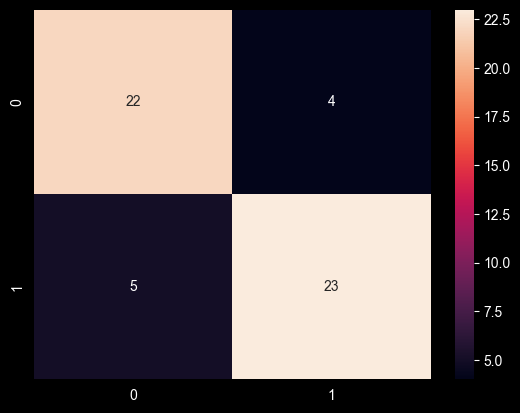

In [13]:
cm = confusion_matrix(rotulos_previus, predict)
sns.heatmap(cm, annot=True)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(rotulos_previus, predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.85      0.82      0.84        28

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



## Finne Tuning - Implementação

In [15]:
#basicamente congelamos certas camdas do modelo pre pronto, e re treinamos apenas as camdas que quisermos
modelo_base.trainable = True
len(modelo_base.layers)
fine_tuning_at = 140



In [16]:
for layer in modelo_base.layers[:fine_tuning_at]:
    layer.trainable = False



In [17]:
my_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
history2 = my_network.fit(training_ds, epochs=100)

Epoch 1/100
7/7 [==============================] - 6s 213ms/step - loss: 0.8209 - accuracy: 0.8744
Epoch 2/100
7/7 [==============================] - 1s 147ms/step - loss: 0.0697 - accuracy: 0.9767
Epoch 3/100
7/7 [==============================] - 1s 152ms/step - loss: 0.0363 - accuracy: 0.9860
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 5/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 6/100
7/7 [==============================] - 1s 143ms/step - loss: 7.6669e-05 - accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 1s 146ms/step - loss: 9.0254e-05 - accuracy: 1.0000
Epoch 8/100
7/7 [==============================] - 1s 142ms/step - loss: 8.1666e-05 - accuracy: 1.0000
Epoch 9/100
7/7 [==============================] - 1s 143ms/step - loss: 2.1327e-05 - accuracy: 1.0000
Epoch 10/100
7/7 [==============================] - 1s 145ms/step - loss: 1.8131e-05 - accura

In [19]:
predict2 = my_network.predict(test_ds)
predict2 = np.argmax(predict2, axis=1)
predict2

2/2 [==============================] - 1s 96ms/step


array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
print(accuracy_score(rotulos_previus, predict2))

0.9259259259259259
